# Initial setup

This analysis using ema is based on the work of Enayat A. Moallemi created on 22 May 2018 at the Fraunhofer ISI, Karlsruhe. In that instance, the analysis was done for the MATISSE model.

In [1]:

"""
Based on Enayat A. Moallemi version from May 2018

edited by Angela M. Rojas A. <angelara@student.unimelb.edu.au>

Created on February 2020

"""

import sys
import os

sys.path.append(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments\EMAworkbench')

sys.path.append(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments')

#from ema_workbench.analysis.plotting_util import BOXPLOT, KDE, VIOLIN
from ema_workbench.analysis.plotting import envelopes
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import matplotlib.cm as cm
import seaborn as sns
from ema_workbench.analysis import prim
#import pareto
import os
import glob
import numpy as np
import pandas as pd
import os
import glob



C:\Users\angel\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\angel\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning:

can't resolve package from __spec__ or __package__, falling back on __name__ and __path__



## Load the results

In [2]:
from ema_workbench import load_results

#results = load_results(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments\data\gr4sp_2020-Feb-20-years.tar.gz')
#results = load_results(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments\data\gr4sp_2020-Feb-07_EET_allV3.tar.gz')
#results = load_results(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments\data\gr4sp_2020-Feb-25-LHS.tar.gz')
results = load_results(r'C:/Users/angel/Documents/GitHub/gr4sp/experiments/simulationData/gr4sp_2020-Jul-28-SOBOL.tar.gz')

experiments, outcomes = results

In [3]:
experiments.describe()

,annualCpi,annualInflation,capacityFactorChangeBrownCoal,capacityFactorChangeWater,consumption,energyEfficiency,generationRolloutPeriod,generatorRetirement,includePublicallyAnnouncedGen,learningCurve,...,priceChangePercentageOcgt,priceChangePercentageWater,priceChangePercentageWind,rooftopPV,scheduleMinCapMarketGen,semiScheduleGenSpotMarket,semiScheduleMinCapMarketGen,solarUptake,technologicalImprovement,wholesaleTariffContribution
count,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,...,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000
mean,0.030000,0.030009,-0.012695,-0.003418,2.002930,0.998535,4.997559,0.000000,0.500000,0.050013,...,-0.011719,0.010254,-0.008301,6.000488,19.999512,8.999023,15.063801,2.000000,0.049981,28.030273
std,0.011547,0.011547,6.058842,6.057041,1.415605,0.816404,3.160687,3.161229,0.500005,0.028866,...,17.607574,17.609114,17.609005,0.816405,6.057687,0.814908,8.631086,1.414918,0.028867,10.101496
min,0.010020,0.010020,-10.000000,-10.000000,0.000000,0.000000,0.000000,-5.000000,0.000000,0.000049,...,-30.000000,-30.000000,-30.000000,5.000000,10.000000,8.000000,0.114600,0.000000,0.000049,11.000000
25%,0.020010,0.020010,-5.000000,-5.000000,1.000000,0.000000,2.000000,-3.000000,0.000000,0.025024,...,-15.000000,-15.000000,-15.000000,5.000000,15.000000,8.000000,7.582300,1.000000,0.025024,19.000000
50%,0.030000,0.030000,0.000000,0.000000,2.000000,1.000000,5.000000,0.000000,0.500000,0.050000,...,0.000000,0.000000,0.000000,6.000000,20.000000,9.000000,15.050000,2.000000,0.050000,28.000000
75%,0.039990,0.039990,5.000000,5.000000,3.000000,2.000000,8.000000,3.000000,1.000000,0.074976,...,15.000000,15.000000,15.000000,7.000000,25.000000,10.000000,22.517700,3.000000,0.074976,37.000000
max,0.049980,0.049980,10.000000,10.000000,4.000000,2.000000,10.000000,5.000000,1.000000,0.099951,...,30.000000,30.000000,30.000000,7.000000,30.000000,10.000000,29.985400,4.000000,0.099951,45.000000


## Load BAU

In [4]:
bau_scenario_id = max(experiments['scenario']) + 1

new_row = pd.DataFrame({'annualCpi': 0.03, 'annualInflation': 0.03, 'capacityFactorChangeBrownCoal': 0,
       'capacityFactorChangeWater': 0, 'consumption': 0, 'energyEfficiency': 0,
       'generationRolloutPeriod':1, 'generatorRetirement':0,
       'includePublicallyAnnouncedGen':0, 'learningCurve':0.05,
       'nonScheduleGenSpotMarket': 10, 'nonScheduleMinCapMarketGen':0.1,
       'priceChangePercentageBrownCoal':0, 'priceChangePercentageOcgt':0,
       'priceChangePercentageWater':0, 'priceChangePercentageWind':0, 'rooftopPV':7,
       'scheduleMinCapMarketGen':30, 'semiScheduleGenSpotMarket':8,
       'semiScheduleMinCapMarketGen':30, 'solarUptake':0,
       'technologicalImprovement':0.01, 'wholesaleTariffContribution':28.37, 'scenario': bau_scenario_id,
       'policy': None, 'model': 'Gr4sp'}, index =[0]) 
# simply concatenate both dataframes 
experiments = pd.concat([experiments,new_row]).reset_index(drop = True) 

In [5]:
bau_results_df = pd.read_csv(r'C:/Users/angel/Documents/GitHub/gr4sp/experiments/simulationData/VICSimDataYearSummary_BAU.csv')

In [6]:
seed_bau = bau_scenario_id + 1
outcomes['TIMEYear'] = np.append(outcomes['TIMEYear'],
                                          [bau_results_df['Time (Year)'].values], axis=0)
outcomes['consumptionYear'] = np.append(outcomes['consumptionYear'],
                                                 [bau_results_df['Consumption (KWh) per household'].values], axis=0)
outcomes['tariffsYear'] = np.append(outcomes['tariffsYear'],
                                                 [bau_results_df[' Avg Tariff (c/KWh) per household'].values], axis=0)
outcomes['wholesalePriceYear'] = np.append(outcomes['wholesalePriceYear'],
                                                 [bau_results_df['Wholesale ($/MWh)'].values], axis=0)
outcomes['GHGYear'] = np.append(outcomes['GHGYear'],
                                                 [bau_results_df['GHG Emissions (tCO2-e) per household'].values], axis=0)
outcomes['numConsumersYear'] = np.append(outcomes['numConsumersYear'],
                                                 [bau_results_df['Number of Domestic Consumers (households)'].values], axis=0)
outcomes['primarySpotProductionYear'] = np.append(outcomes['primarySpotProductionYear'],
                                                 [bau_results_df['System Production Primary Spot'].values], axis=0)
outcomes['secondarySpotProductionYear'] = np.append(outcomes['secondarySpotProductionYear'],
                                                 [bau_results_df['System Production Secondary Spot'].values], axis=0)
outcomes['offSpotProductionYear'] = np.append(outcomes['offSpotProductionYear'],
                                                 [bau_results_df['System Production Off Spot'].values], axis=0)
outcomes['renewableContributionYear'] = np.append(outcomes['renewableContributionYear'],
                                                 [bau_results_df['Percentage Renewable Production'].values], axis=0)
outcomes['rooftopPVProductionYear'] = np.append(outcomes['rooftopPVProductionYear'],
                                                 [bau_results_df['System Production Rooftop PV'].values], axis=0)
outcomes['coalProductionYear'] = np.append(outcomes['coalProductionYear'],
                                                 [bau_results_df['System Production Coal'].values], axis=0)
outcomes['windProductionYear'] = np.append(outcomes['windProductionYear'],
                                                 [bau_results_df['System Production Wind'].values], axis=0)
outcomes['gasProductionYear'] = np.append(outcomes['gasProductionYear'],
                                                 [bau_results_df['System Production Gas'].values], axis=0)
outcomes['solarProductionYear'] = np.append(outcomes['solarProductionYear'],
                                                 [bau_results_df['System Production Solar'].values], axis=0)   
outcomes['waterProductionYear'] = np.append(outcomes['waterProductionYear'],
                                                 [bau_results_df['System Production Water'].values], axis=0)
outcomes['BatteryProductionYear'] = np.append(outcomes['BatteryProductionYear'],
                                                 [bau_results_df['System Production Battery'].values], axis=0)
outcomes['numActorsYear'] = np.append(outcomes['numActorsYear'],
                                                 [bau_results_df['Number of Active Actors'].values], axis=0)
outcomes['seedExperimentCsv'] = np.append(outcomes['seedExperimentCsv'], [seed_bau], axis=0)


## General parameters

In [7]:
outcomes_to_show = ['consumptionYear', 'tariffsYear', 'wholesalePriceYear', 'GHGYear', 
                    'primarySpotProductionYear', 'secondarySpotProductionYear', 
                    'offSpotProductionYear', 'renewableContributionYear', 'rooftopPVProductionYear', 
                    'coalProductionYear', 'waterProductionYear', 'windProductionYear', 'gasProductionYear', 
                    'solarProductionYear', 'BatteryProductionYear']

# 23 levers/uncertainties selected after EET (last test July 2020)
uncertainties = experiments.columns[:-3]

#from startYear
startYear = 2000
startYearShift = (startYear - 1998)

time = outcomes['TIMEYear'][0, startYearShift:]

points_of_interest = [*range(2000,2051,10)] 
points_of_interest = [ x - startYear for x in points_of_interest]

# Filter outcomes taking into account the startYear, and removing Seed Experiment info. 
# Seed it is useful if I want to retrieve more info from the csv files, or redo the experiments with the
# simulation parameters
outcomes_filtered = {k:v[:, startYearShift:] for k,v in outcomes.items() if k != 'seedExperimentCsv'}


## Aggregate Household data

GHG emissions and Consumption per household type converted to total sector


In [8]:
ooi = 'GHGYear'
data_GHG_household = outcomes_filtered[ooi]

In [9]:
""" Converts household data in tCO2e into total residential data in MtCO2e"""
data_GHG_residential = (data_GHG_household * outcomes_filtered['numConsumersYear']) / 1000000.0

""" Applies scaling factor used in simulation, so that data represents total emissions, not only residential (30%)"""
data_GHG_total = data_GHG_residential / 0.3

"""Overwrite GHG with the data of interest"""
outcomes_filtered[ooi] = data_GHG_total

In [10]:
ooi = 'consumptionYear'
data_consumption_household = outcomes_filtered[ooi]

In [11]:
""" Converts household data in KWh into total residential data in MWh"""
data_consumption_residential = (data_consumption_household * outcomes_filtered['numConsumersYear']) / 1000.0

""" Applies scaling factor used in simulation, so that data represents total consumption, not only residential"""
data_consumption_total = data_consumption_residential / 0.3

"""Overwrite Consumption with the data of interest"""
outcomes_filtered[ooi] = data_consumption_total

# Target functions

In [12]:
def target_always_after(outcomes,ooi,targetYear,targetVal,above):
    data = outcomes[ooi]
    num_exp = len(data)
    achieved = np.zeros(num_exp, dtype=bool)

    for i in range(num_exp):
        achieved[i] = False
        exp_run = data[i]
        for j in range( len(exp_run) ):
            if (startYear + j) >= targetYear:
                if above is True:
                    achieved[i] = exp_run[j] >= targetVal
                else:
                    achieved[i] = exp_run[j] < targetVal
                    
                #If the target is not achieved after the TargetYear, then mark experiment as False
                if achieved[i] == False:
                    break
    return achieved

def target_at_year(outcomes,ooi,targetYear,targetVal,above):
    data = outcomes[ooi]
    num_exp = len(data)
    achieved = np.zeros(num_exp, dtype=bool)

    for i in range(num_exp):
        achieved[i] = False
        exp_run = data[i]
        
        idx = targetYear - startYear
        if above is True:
            achieved[i] = exp_run[idx] >= targetVal
        else:
            achieved[i] = exp_run[idx] < targetVal                        
                
    return achieved

# Scenario discovery

## GHG emissions


Truncate experiments and outcomes for a selected policy and a selected outcome over mean in time series

In [14]:
#Subset of levers/uncertainties
#selected_levers = list(['rooftopPV', 'annualCpi','capacityFactorChangeBrownCoal','capacityFactorChangeWater','semiScheduleMinCapMarketGen'])    
selected_uncertainties = uncertainties

ooi = 'GHGYear'

data = outcomes_filtered[ooi]


num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_uncertainties] 

The following section uses PRIM, feature scoring and dimensional stacking to find the cases that represent futures in three main groups: Low Carbon, Just Transition and Resilient Transition.

It uses targets (e.g. cases for which emissions are the lowest at year x) to filter out the cases and find out the corresponding input variables and ranges for the cases to happen.

The first case is on GHG emissions. To find out the targets for exploration, first let's analyse the envelope diagram (see below) showing how the transition may unfold:

### Open Exploration: Visual Analysis

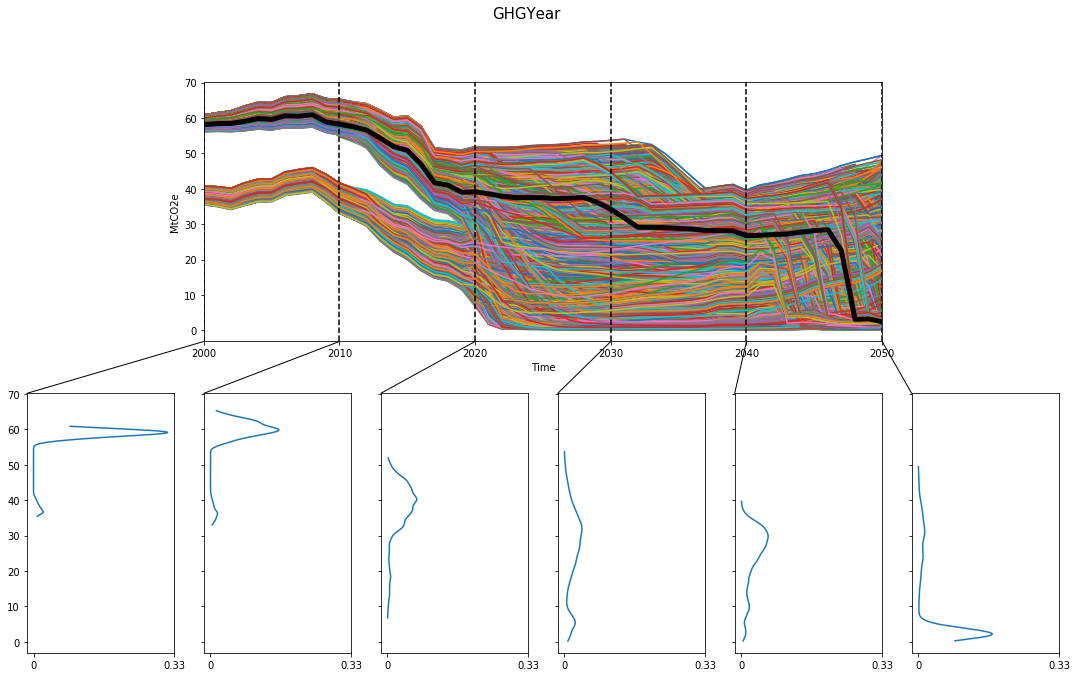

In [308]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density 

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest, density = Density.KDE, grouping_specifiers=None, 
                                 titles={ooi}, ylabels={ooi: "MtCO2e"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

#Add BAU in the plot with a gray wide line
ax_env[ooi]['main plot'].plot(outcomes_filtered[ooi][-1], 'k-',linewidth=5 )

## Show labels
# labels = ax_env['F']['main plot'].get_xticklabels()
# for l in labels:
#     print (l.get_text)

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')
    

Densities (PDF): {'35.5 to 37.8': '0.021', '37.8 to 40.1': '0.011', '40.1 to 42.4': '0.002', '56.3 to 58.6': '0.121', '58.6 to 60.9': '0.277'}
% in Bin: {'35.5 to 37.8': '4.9%', '37.8 to 40.1': '2.6%', '40.1 to 42.4': '0.5%', '42.4 to 44.7': '0.0%', '44.7 to 47.0': '0.0%', '47.0 to 49.3': '0.0%', '49.3 to 51.6': '0.0%', '51.6 to 54.0': '0.0%', '54.0 to 56.3': '0.1%', '56.3 to 58.6': '28.0%', '58.6 to 60.9': '63.9%'}

Densities (PDF): {'33.0 to 36.0': '0.011', '36.0 to 38.9': '0.013', '38.9 to 41.8': '0.003', '53.6 to 56.5': '0.014', '56.5 to 59.4': '0.096', '59.4 to 62.4': '0.147', '62.4 to 65.3': '0.057'}
% in Bin: {'33.0 to 36.0': '3.3%', '36.0 to 38.9': '3.8%', '38.9 to 41.8': '1.0%', '41.8 to 44.8': '0.0%', '44.8 to 47.7': '0.0%', '47.7 to 50.6': '0.0%', '50.6 to 53.6': '0.0%', '53.6 to 56.5': '4.1%', '56.5 to 59.4': '28.0%', '59.4 to 62.4': '43.1%', '62.4 to 65.3': '16.7%'}

Densities (PDF): {'6.8 to 10.9': '0.001', '10.9 to 15.0': '0.005', '15.0 to 19.1': '0.006', '19.1 to 23.2':

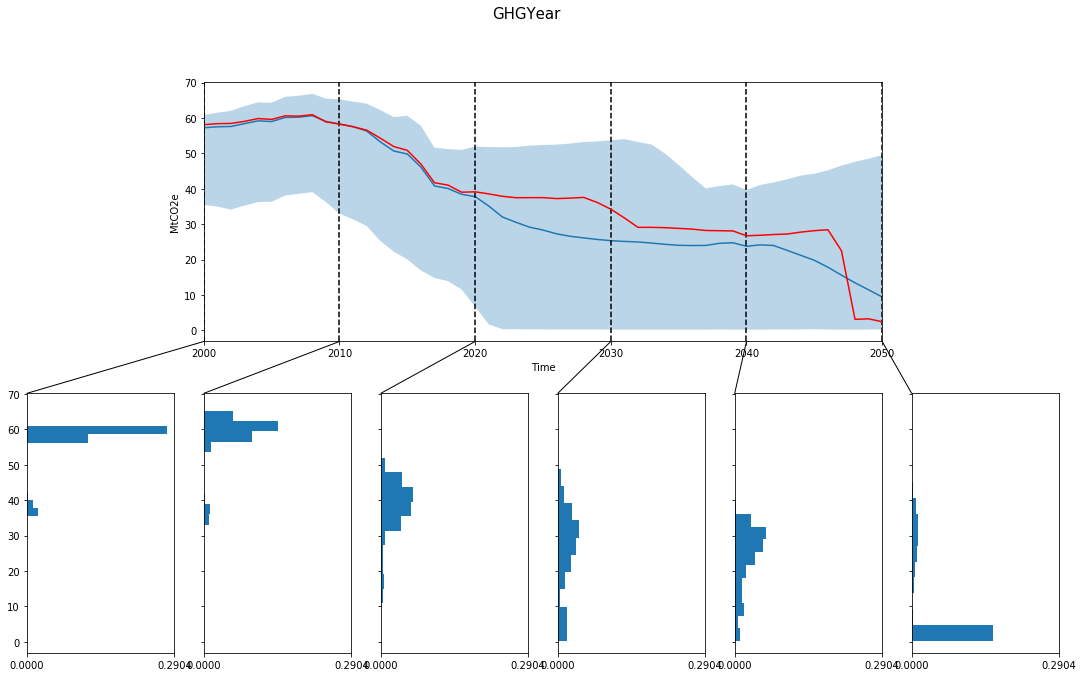

In [26]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density 

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest, density = Density.HIST, grouping_specifiers=None,
                                 titles={ooi}, ylabels={ooi: "MtCO2e"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

#Add BAU in the plot with a gray red line
ax_env[ooi]['main plot'].plot(outcomes_filtered[ooi][-1], 'r-')

## Show labels
# labels = ax_env['F']['main plot'].get_xticklabels()
# for l in labels:
#     print (l.get_text)

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')


#### Filter bottom cluster below BAU in the region 2000 - 2020

In [279]:
filter_below = target_at_year( outcomes_filtered, ooi, 2000, 50, True) #True means above target
outcomes_bau_cluster = {k:v[filter_below, :] for k,v in outcomes_filtered.items()}

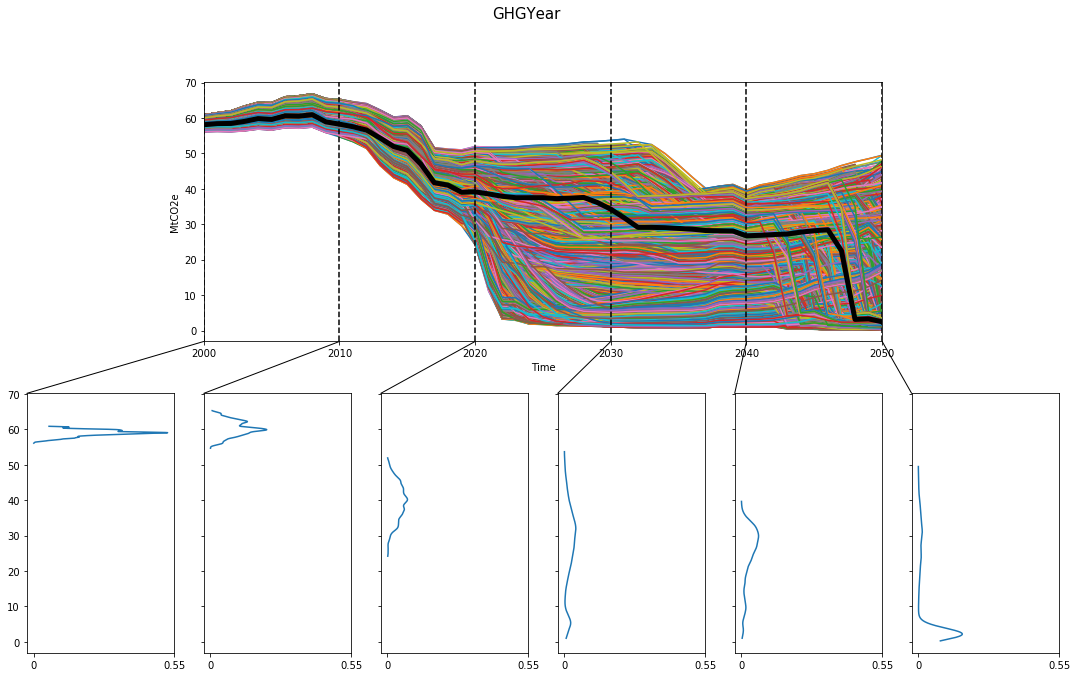

In [280]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density 

fig, ax_env = multiple_densities(experiments, outcomes_bau_cluster, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest, density = Density.KDE, grouping_specifiers=None, 
                                 titles={ooi}, ylabels={ooi: "MtCO2e"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

#Add BAU in the plot with a gray wide line
ax_env[ooi]['main plot'].plot(outcomes_filtered[ooi][-1], 'k-',linewidth=5 )

## Show labels
# labels = ax_env['F']['main plot'].get_xticklabels()
# for l in labels:
#     print (l.get_text)

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')
    

Densities (PDF): {'56.1 to 56.6': '0.003', '56.6 to 57.0': '0.050', '57.0 to 57.4': '0.107', '57.4 to 57.8': '0.177', '57.8 to 58.3': '0.178', '58.3 to 58.7': '0.292', '58.7 to 59.1': '0.479', '59.1 to 59.6': '0.373', '59.6 to 60.0': '0.338', '60.0 to 60.4': '0.174', '60.4 to 60.9': '0.138'}
% in Bin: {'56.1 to 56.6': '0.1%', '56.6 to 57.0': '2.1%', '57.0 to 57.4': '4.6%', '57.4 to 57.8': '7.7%', '57.8 to 58.3': '7.7%', '58.3 to 58.7': '12.7%', '58.7 to 59.1': '20.7%', '59.1 to 59.6': '16.1%', '59.6 to 60.0': '14.6%', '60.0 to 60.4': '7.6%', '60.4 to 60.9': '6.0%'}

Densities (PDF): {'54.7 to 55.7': '0.006', '55.7 to 56.6': '0.046', '56.6 to 57.6': '0.060', '57.6 to 58.5': '0.111', '58.5 to 59.5': '0.152', '59.5 to 60.5': '0.216', '60.5 to 61.4': '0.122', '61.4 to 62.4': '0.139', '62.4 to 63.4': '0.102', '63.4 to 64.3': '0.051', '64.3 to 65.3': '0.031'}
% in Bin: {'54.7 to 55.7': '0.5%', '55.7 to 56.6': '4.4%', '56.6 to 57.6': '5.8%', '57.6 to 58.5': '10.8%', '58.5 to 59.5': '14.7%', '

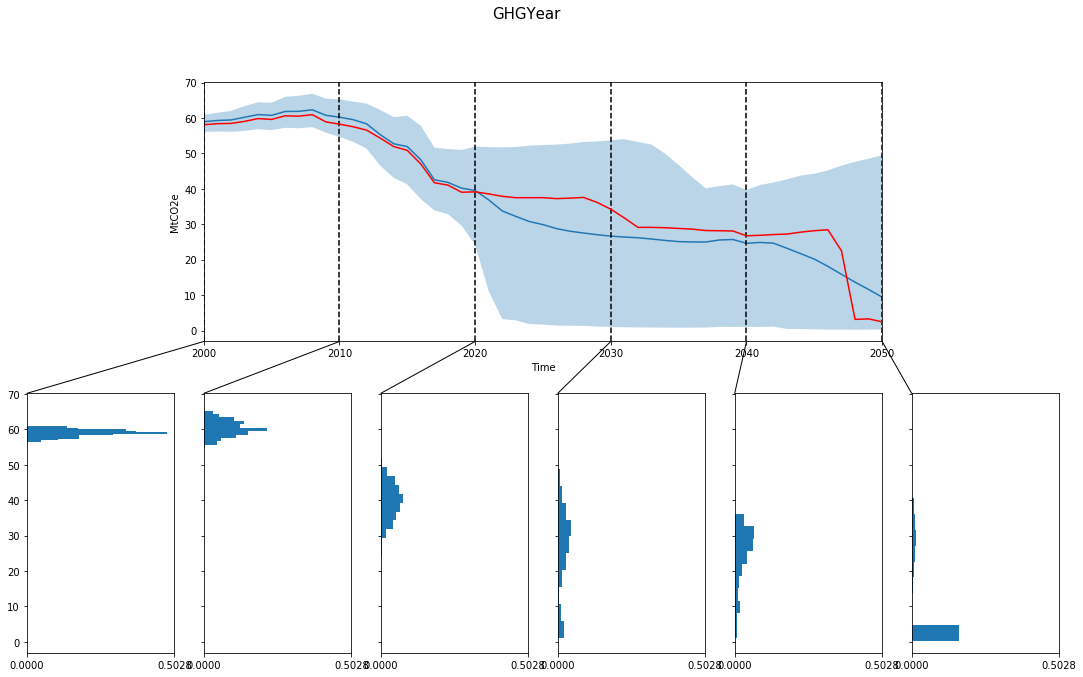

In [281]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density 

fig, ax_env = multiple_densities(experiments, outcomes_bau_cluster, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest, density = Density.HIST, grouping_specifiers=None,
                                 titles={ooi}, ylabels={ooi: "MtCO2e"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

#Add BAU in the plot with a gray red line
ax_env[ooi]['main plot'].plot(outcomes_filtered[ooi][-1], 'r-')

## Show labels
# labels = ax_env['F']['main plot'].get_xticklabels()
# for l in labels:
#     print (l.get_text)

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')


As the envelope shows, there are two main groups at the first years of analysis where GHG emissions either increase or decrease. However, as time passes, GHG emissions can vary widely. 
Taking the first year of analysis, year 2020, we can investigate the cases where GHG emissions per year per household fall below 30.89 MtonsCO2-e. This is 20% lower than the emissions in BAU for 2005, which were 38.62 MtCO2-e

### Scenario Discovery: Prim

Victoria's Climate Change Act 2017: “These targets build on the progress that Victoria is already making; emissions are projected to fall to 18% below 2005 levels in 2020.”
The Panel recommends interim targets of:
•	32-39% below 2005 levels in 2025
•	45-60% below 2005 levels in 2030

In [27]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
ooi = 'GHGYear'
#y = (out_avg_ooi < 4.)
#y = target_at_year( outcomes_filtered, ooi, 2030, 24, False) #False is below target
y = target_at_year( outcomes_filtered, ooi, 2020, 38, False) #False is below target

#Threshold for density
prim_alg = prim.Prim(x, y, threshold=0.3)
box1 = prim_alg.find_box()

[MainProcess/INFO] 49153 points remaining, containing 21310 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.1740280349113991, coverage: 0.40140778977006103, density: 1.0 restricted_dimensions: 5


In [29]:
box1.inspect_tradeoff()

alt.VConcatChart(...)

coverage    0.831805
density     0.578361
id                 5
mass        0.188232
mean        0.578361
res_dim            4
Name: 5, dtype: object

                           box 5                                      
                             min   max                       qp values
semiScheduleGenSpotMarket    8.0   8.5                     [-1.0, 0.0]
nonScheduleGenSpotMarket     8.0   9.5  [-1.0, 2.607724097091756e-299]
generatorRetirement         -4.5   5.0  [1.3863604374923813e-08, -1.0]
priceChangePercentageWater -26.5  30.0  [3.9306507750370204e-05, -1.0]



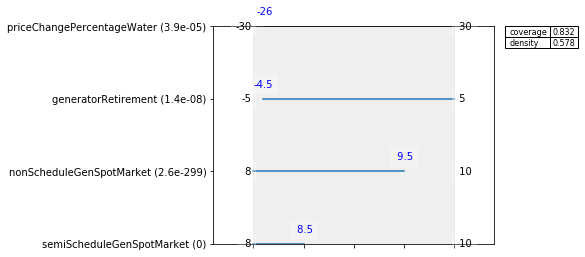

In [65]:
#%matplotlib inline
selected_box = 5

box_1 = box1.inspect(selected_box)
box_1 = box1.inspect(selected_box, style='graph')


"The quasi-p-value test, essentially a one sided binomial test, is an estimate of the likelihood that a given uncertainty is included in the definition of the subspace purely by chance." (Bryant and Lempert, 2010)

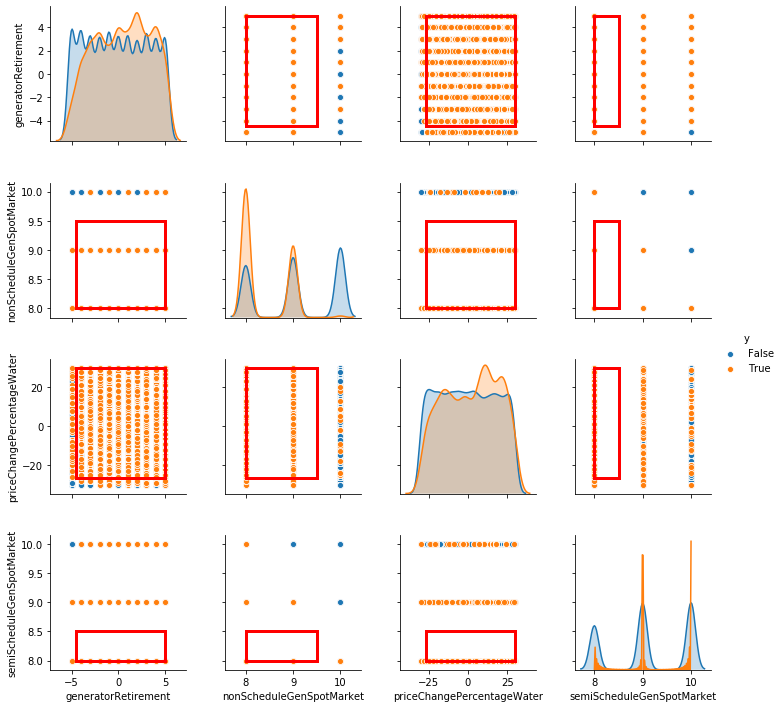

In [66]:
box1.select(selected_box)
fig = box1.show_pairs_scatter(selected_box)

plt.show()


### Feature Scoring

In [67]:
from EMAworkbench.ema_workbench.analysis import feature_scoring

fs, alg = feature_scoring.get_ex_feature_scores(x, y, mode=feature_scoring.RuleInductionType.CLASSIFICATION)
fs.sort_values(ascending=False, by=1)



,1
0,
semiScheduleGenSpotMarket,0.331916
nonScheduleGenSpotMarket,0.191243
generationRolloutPeriod,0.075621
semiScheduleMinCapMarketGen,0.043976
capacityFactorChangeBrownCoal,0.036340
consumption,0.031744
nonScheduleMinCapMarketGen,0.030624
generatorRetirement,0.024738
includePublicallyAnnouncedGen,0.022140


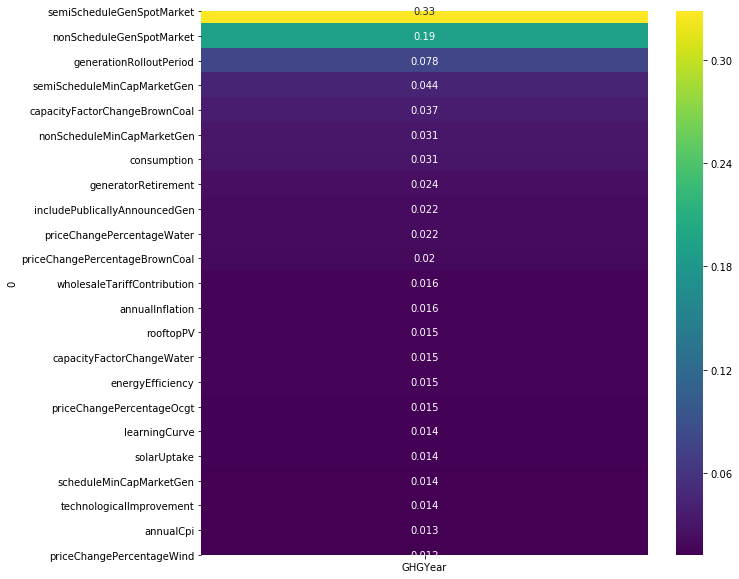

In [68]:
x = exp
y_all = {}

#plot using ALL simulations
#y_all['GHGYear'] = data

#plot using average of ALL simulations
#y_all['GHGYear'] = out_avg_ooi

#Plot using only target simulations
y_all['GHGYear'] = y

fig, ax = plt.subplots(figsize=(10,10))
fs = feature_scoring.get_feature_scores_all(x, y_all)
sns.heatmap(fs, cmap='viridis', annot=True, ax=ax)
plt.show()

### Dimensional Stacking


In [ ]:

from EMAworkbench.ema_workbench.analysis import dimensional_stacking

x = exp
dimensional_stacking.create_pivot_plot(x,y, 2, nbins=3)
plt.show()



## Wholesale Price

In [15]:
# Subset Sobol levers
#selected_levers = list(['rooftopPV','annualCpi', 'generationRolloutPeriod', 'generatorRetirement','capacityFactorChangeBrownCoal','semiScheduleMinCapMarketGen'])    

select_uncertainties = uncertainties
ooi = 'wholesalePriceYear'
data = outcomes_filtered[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, select_uncertainties] 

### Open Exploration: Visual Analysis

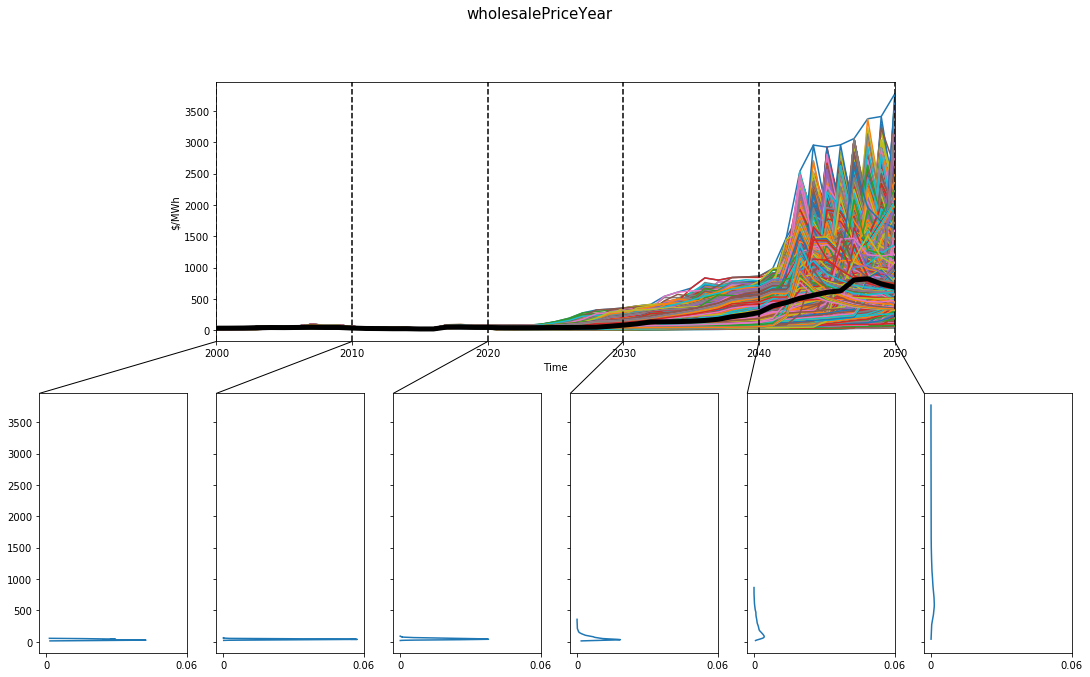

In [283]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density 

# fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
#                                  points_in_time=points_of_interest,  density = Density.KDE,
#                                  grouping_specifiers=None , titles={ooi}, ylabels={ooi: "$/MWh"}, legend=True,
#                                  fill=False, plot_type=PlotType.ENV_LIN)

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "$/MWh"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)
#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])
#Add BAU in the plot with a black wide line
ax_env[ooi]['main plot'].plot(outcomes_filtered[ooi][-1], 'k-',linewidth=5 )

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

Densities (PDF): {'14.1 to 17.8': '0.007', '17.8 to 21.5': '0.023', '21.5 to 25.3': '0.038', '25.3 to 29.0': '0.039', '29.0 to 32.8': '0.025', '32.8 to 36.5': '0.027', '36.5 to 40.3': '0.028', '40.3 to 44.0': '0.030', '44.0 to 47.7': '0.026', '47.7 to 51.5': '0.018', '51.5 to 55.2': '0.006'}
% in Bin: {'14.1 to 17.8': '2.7%', '17.8 to 21.5': '8.5%', '21.5 to 25.3': '14.2%', '25.3 to 29.0': '14.8%', '29.0 to 32.8': '9.5%', '32.8 to 36.5': '10.1%', '36.5 to 40.3': '10.5%', '40.3 to 44.0': '11.1%', '44.0 to 47.7': '9.7%', '47.7 to 51.5': '6.8%', '51.5 to 55.2': '2.1%'}

Densities (PDF): {'22.2 to 25.9': '0.002', '25.9 to 29.6': '0.017', '29.6 to 33.3': '0.037', '33.3 to 37.0': '0.048', '37.0 to 40.8': '0.056', '40.8 to 44.5': '0.052', '44.5 to 48.2': '0.035', '48.2 to 51.9': '0.015', '51.9 to 55.7': '0.004', '55.7 to 59.4': '0.001'}
% in Bin: {'22.2 to 25.9': '0.8%', '25.9 to 29.6': '6.4%', '29.6 to 33.3': '13.8%', '33.3 to 37.0': '18.0%', '37.0 to 40.8': '21.0%', '40.8 to 44.5': '19.5%',

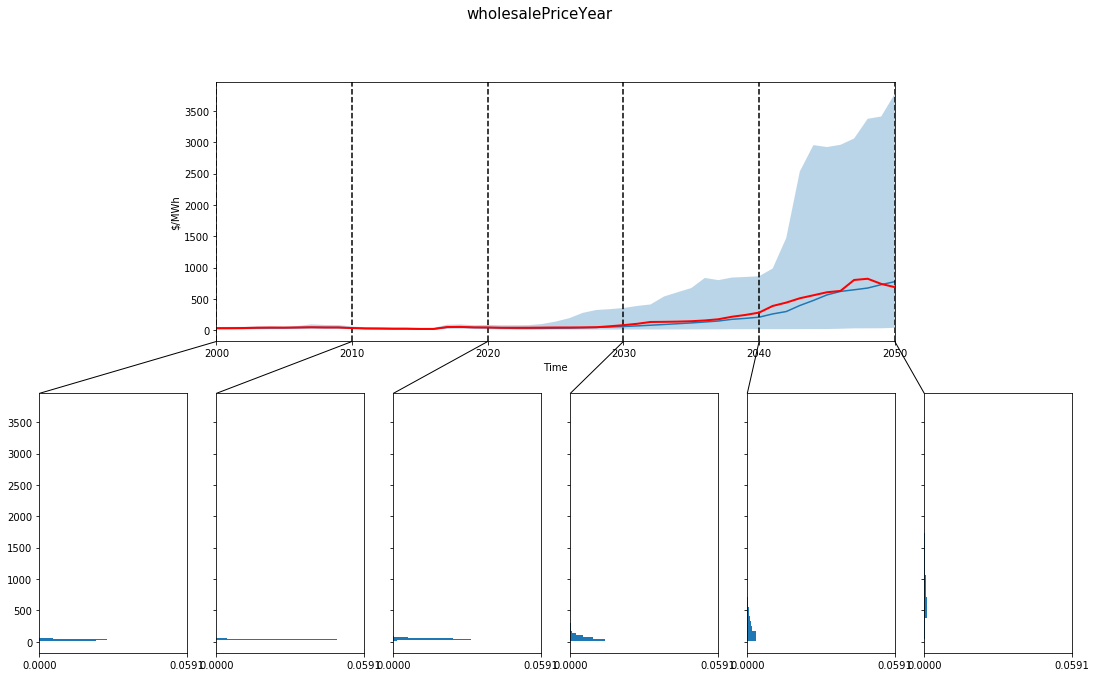

In [297]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

# fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
#                                  points_in_time=points_of_interest,  density = Density.HIST,
#                                  grouping_specifiers=None , titles={ooi}, ylabels={ooi: "$/MWh"}, legend=True,
#                                  fill=True, plot_type=PlotType.ENVELOPE)

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.HIST,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "$/MWh"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])
#Add BAU in the plot with a red wide line
ax_env[ooi]['main plot'].plot(outcomes_filtered[ooi][-1], 'r-',linewidth=2 )

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')



Wholesale prices: 20-25% by 2025 on 2017 levels
Spot price in 2017 ~103 $/MWh (OpenNem) in simulation BAU VIC 48.05. In 2025 should be below 38.44-36.03 (20-25%)

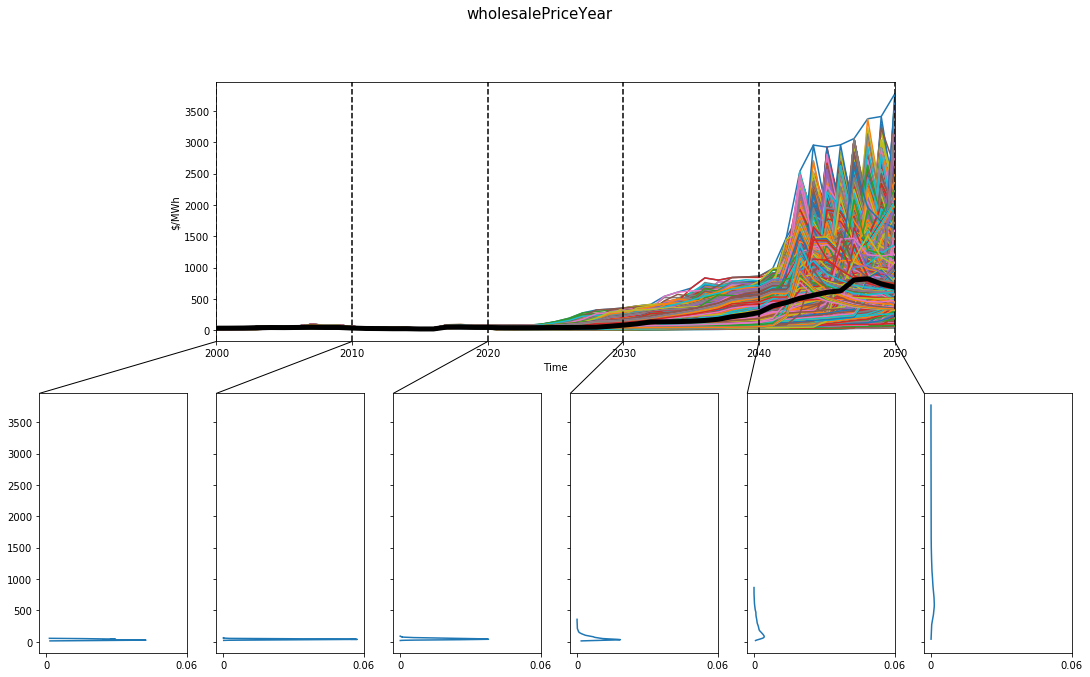

In [285]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density 

# fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
#                                  points_in_time=points_of_interest,  density = Density.KDE,
#                                  grouping_specifiers=None , titles={ooi}, ylabels={ooi: "$/MWh"}, legend=True,
#                                  fill=False, plot_type=PlotType.ENV_LIN)

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "$/MWh"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)
#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])
#Add BAU in the plot with a black wide line
ax_env[ooi]['main plot'].plot(outcomes_filtered[ooi][-1], 'k-',linewidth=5 )

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

Densities (PDF): {'29.7 to 30.0': '0.099', '30.0 to 30.2': '0.354', '30.2 to 30.5': '0.603', '30.5 to 30.7': '0.594', '30.7 to 30.9': '0.412', '30.9 to 31.2': '0.434', '31.2 to 31.4': '0.438', '31.4 to 31.7': '0.462', '31.7 to 31.9': '0.398', '31.9 to 32.2': '0.223', '32.2 to 32.4': '0.050'}
% in Bin: {'29.7 to 30.0': '2.4%', '30.0 to 30.2': '8.7%', '30.2 to 30.5': '14.8%', '30.5 to 30.7': '14.6%', '30.7 to 30.9': '10.1%', '30.9 to 31.2': '10.7%', '31.2 to 31.4': '10.8%', '31.4 to 31.7': '11.4%', '31.7 to 31.9': '9.8%', '31.9 to 32.2': '5.5%', '32.2 to 32.4': '1.2%'}

Densities (PDF): {'13.8 to 16.7': '0.002', '16.7 to 19.6': '0.013', '19.6 to 22.5': '0.044', '22.5 to 25.4': '0.073', '25.4 to 28.3': '0.091', '28.3 to 31.2': '0.068', '31.2 to 34.1': '0.033', '34.1 to 37.0': '0.014', '37.0 to 39.9': '0.006'}
% in Bin: {'13.8 to 16.7': '0.6%', '16.7 to 19.6': '3.7%', '19.6 to 22.5': '12.9%', '22.5 to 25.4': '21.1%', '25.4 to 28.3': '26.3%', '28.3 to 31.2': '19.7%', '31.2 to 34.1': '9.5%',

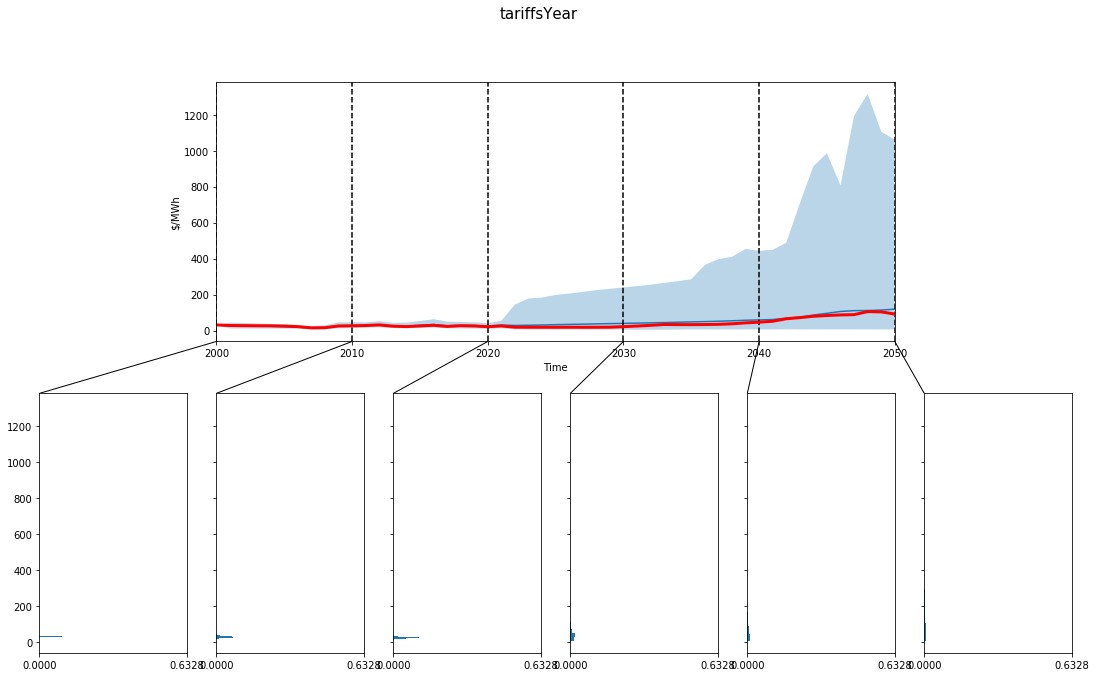

In [294]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

# fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
#                                  points_in_time=points_of_interest,  density = Density.HIST,
#                                  grouping_specifiers=None , titles={ooi}, ylabels={ooi: "$/MWh"}, legend=True,
#                                  fill=True, plot_type=PlotType.ENVELOPE)

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.HIST,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "$/MWh"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])
#Add BAU in the plot with a red wide line
ax_env[ooi]['main plot'].plot(outcomes_filtered[ooi][-1], 'r-',linewidth=3 )

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')



Wholesale prices: 20-25% by 2025 on 2017 levels
Spot price in 2017 ~103 $/MWh (OpenNem) in simulation BAU VIC 48.05. In 2025 should be below 38.44-36.03 (20-25%)

In [32]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO); 
x = exp
#y = out_avg_ooi > 80

y = target_at_year( outcomes_filtered, ooi, 2030, 46, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=.8, threshold_type=prim.ABOVE)
box1 = prim_alg.find_box()

[MainProcess/INFO] 49153 points remaining, containing 21903 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.06913108050373325, coverage: 0.15513856549331143, density: 1.0 restricted_dimensions: 7


In [33]:
box1.inspect_tradeoff()

alt.VConcatChart(...)

We can see that the targets are __not ambitious enough__, and is sufficient to __delay slightly the rollout of renewables__, and **avoid the earliest retirement of brown coal**

coverage    0.508163
density     0.815028
id                 3
mass        0.303786
mean        0.815028
res_dim            3
Name: 3, dtype: object

                              box 3                                     
                                min   max                      qp values
includePublicallyAnnouncedGen   0.5   1.0                    [0.0, -1.0]
semiScheduleGenSpotMarket       8.5  10.0                    [0.0, -1.0]
generationRolloutPeriod         0.5  10.0  [5.407118507059046e-68, -1.0]



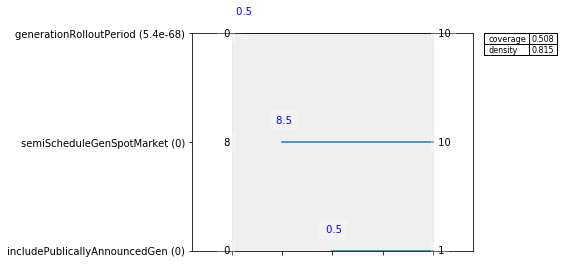

In [19]:
%matplotlib inline
box_1 = box1.inspect(3)
box_1 = box1.inspect(3, style='graph')

### Feature Scoring

In [20]:
from EMAworkbench.ema_workbench.analysis import feature_scoring

fs, alg = feature_scoring.get_ex_feature_scores(x, y, mode=feature_scoring.RuleInductionType.CLASSIFICATION)
fs.sort_values(ascending=False, by=1)


,1
0,
generatorRetirement,0.231507
semiScheduleGenSpotMarket,0.220452
consumption,0.085820
includePublicallyAnnouncedGen,0.080848
generationRolloutPeriod,0.066415
priceChangePercentageWater,0.036840
annualInflation,0.035610
semiScheduleMinCapMarketGen,0.019934
energyEfficiency,0.019555


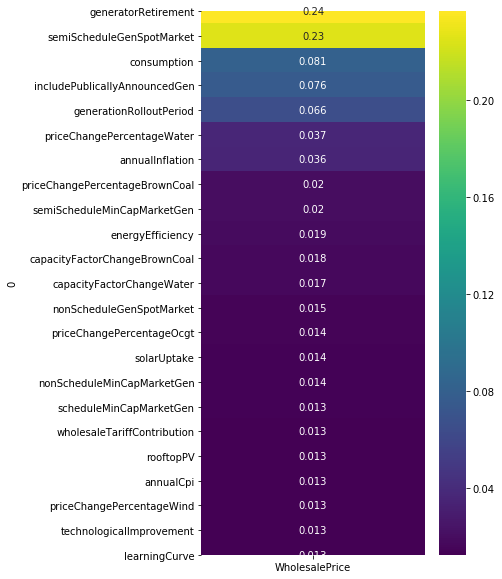

In [21]:
x = exp
y_all = {}

#plot using ALL simulations
#y_all['GHGYear'] = data

#plot using average of ALL simulations
#y_all['GHGYear'] = out_avg_ooi

#Plot using only target simulations
y_all['WholesalePrice'] = y

fig, ax = plt.subplots(figsize=(5,10))
fs = feature_scoring.get_feature_scores_all(x, y_all)
sns.heatmap(fs, cmap='viridis', annot=True, ax=ax)
plt.show()

### Dimensional stacking

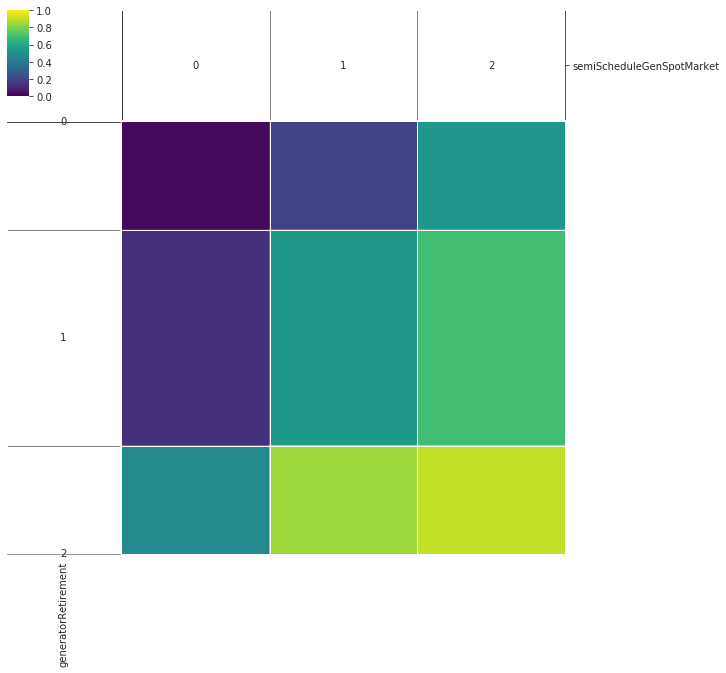

In [22]:

from EMAworkbench.ema_workbench.analysis import dimensional_stacking

x = exp
dimensional_stacking.create_pivot_plot(x,y, 1, nbins=3)
plt.show()



### A more ambitious target
Wholesale prices: 50% by 2025 on 2017 levels
Spot price in 2017 ~103 $/MWh (OpenNem) in simulation BAU VIC 48.05. In 2025 should be below 24.02 (50%)

In [30]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 80

y = target_at_year( outcomes_filtered, ooi, 2040, 50, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=.35, threshold_type=prim.ABOVE)
box1 = prim_alg.find_box()

[MainProcess/INFO] 49153 points remaining, containing 2338 cases of interest
[MainProcess/INFO] mean: 0.409373060211049, mass: 0.06555042418570586, coverage: 0.5641573994867408, density: 0.409373060211049 restricted_dimensions: 8


In [31]:
box1.inspect_tradeoff()

alt.VConcatChart(...)

In [ ]:
%matplotlib inline
box_1 = box1.inspect(3)
box_1 = box1.inspect(13, style='graph')


In [ ]:
box1.select(13)
fig = box1.show_pairs_scatter(13)

plt.show()

### Feature Scoring

In [ ]:
from EMAworkbench.ema_workbench.analysis import feature_scoring

fs, alg = feature_scoring.get_ex_feature_scores(x, y, mode=feature_scoring.RuleInductionType.CLASSIFICATION)
fs.sort_values(ascending=False, by=1)


In [ ]:
x = exp
y_all = {}

#plot using ALL simulations
#y_all['GHGYear'] = data

#plot using average of ALL simulations
#y_all['GHGYear'] = out_avg_ooi

#Plot using only target simulations
y_all['WholesalePrice'] = y

fig, ax = plt.subplots(figsize=(5,10))
fs = feature_scoring.get_feature_scores_all(x, y_all)
sns.heatmap(fs, cmap='viridis', annot=True, ax=ax)
plt.show()

### Dimensional stacking

In [ ]:

from EMAworkbench.ema_workbench.analysis import dimensional_stacking

x = exp
dimensional_stacking.create_pivot_plot(x,y, 1, nbins=3)
plt.show()



## Tariffs

In [34]:
# Subset Sool levers/uncertainties
selected_uncertainties = uncertainties

#selected_levers = levers
ooi = 'tariffsYear'
data = outcomes_filtered[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_uncertainties] 

: 20-25% by 2025 on 2017. tariffs in 2017: ~21 c/KWh

### Open Exploration: Visual Analysis

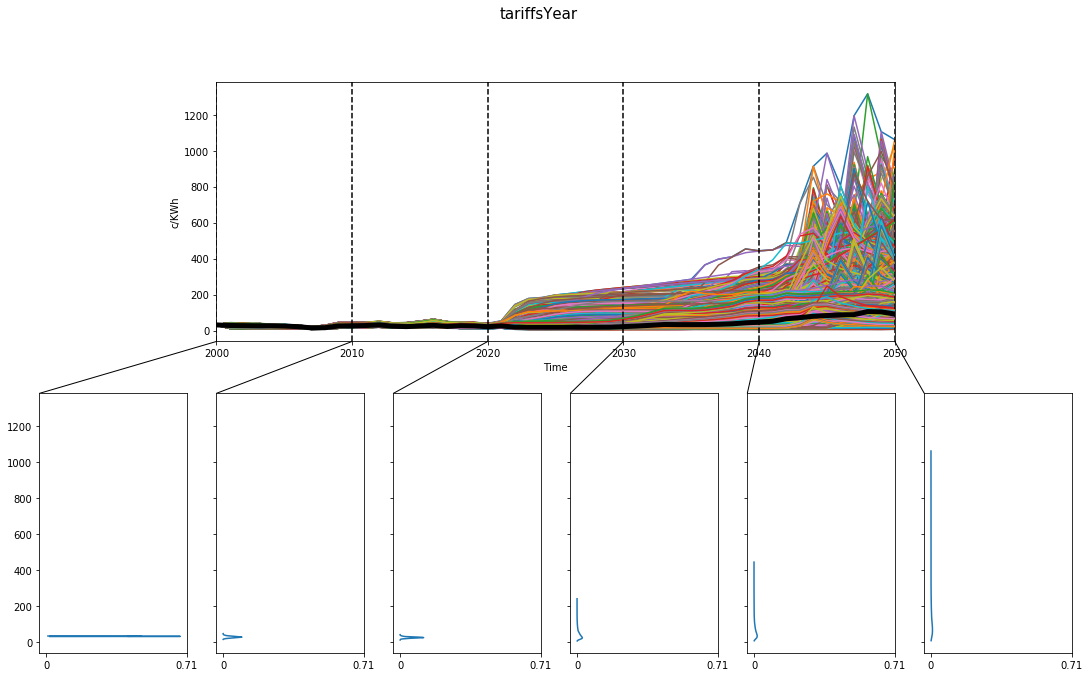

In [291]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "c/KWh"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])
#Add BAU in the plot with a black wide line
ax_env[ooi]['main plot'].plot(outcomes_filtered[ooi][-1], 'k-',linewidth=5 )


fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

In [ ]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.HIST,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "c/KWh"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])
#Add BAU in the plot with a red wide line
ax_env[ooi]['main plot'].plot(outcomes_filtered[ooi][-1], 'r-',linewidth=2 )


fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')


In [51]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);

x = exp
"""
Filter by GHG
"""    
ooi = 'GHGYear'
#y = (out_avg_ooi < 4.)
#y = target_at_year( outcomes_filtered, ooi, 2030, 24, False) #False is below target
y1 = target_at_year( outcomes_filtered, ooi, 2030, 25, False) #False is below target

"""
Filter by Wholesale price
"""

ooi = 'wholesalePriceYear'    

#y = out_avg_ooi > 20

y2 = target_at_year( outcomes_filtered, ooi, 2030, 50, False) #False is below target
#y = target_at_year( outcomes_filtered, ooi, 2030, 21, False) #False is below target

"""
Filter by Tariff
"""

ooi = 'tariffsYear'    

#y = out_avg_ooi > 20

y3 = target_at_year( outcomes_filtered, ooi, 2030, 21, False) #False is below target
#y = target_at_year( outcomes_filtered, ooi, 2030, 21, False) #False is below target

"""
Combine Filters
"""
y = y1 & y2 & y3

"""
Run PRIM
"""
prim_alg = prim.Prim(x, y, threshold=0.1, threshold_type=prim.ABOVE)
box1 = prim_alg.find_box()

[MainProcess/INFO] 49153 points remaining, containing 1291 cases of interest
[MainProcess/INFO] mean: 0.23065192527640108, mass: 0.053363985921510385, coverage: 0.4686289697908598, density: 0.23065192527640108 restricted_dimensions: 13


In [52]:
box1.inspect_tradeoff()

alt.VConcatChart(...)

coverage     0.68629
density     0.139111
id                32
mass        0.129575
mean        0.139111
res_dim           11
Name: 32, dtype: object

                                   box 32             \
                                      min        max   
priceChangePercentageWind      -30.000000  12.500000   
annualInflation                  0.010020   0.040781   
priceChangePercentageWater     -30.000000  23.500000   
capacityFactorChangeBrownCoal  -10.000000   8.500000   
technologicalImprovement         0.000049   0.095996   
wholesaleTariffContribution     29.500000  45.000000   
priceChangePercentageBrownCoal -23.500000  30.000000   
generationRolloutPeriod          0.500000  10.000000   
annualCpi                        0.011992   0.049980   
learningCurve                    0.004395   0.099951   
scheduleMinCapMarketGen         10.500000  30.000000   

                                                                
                                                     qp

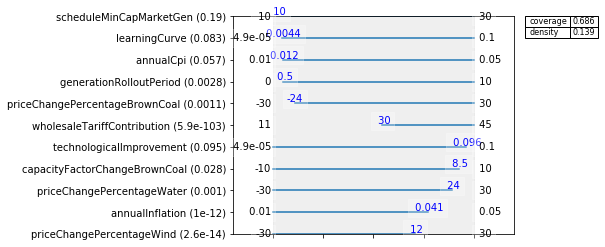

In [53]:
%matplotlib inline
box_1 = box1.inspect(32)
box_1 = box1.inspect(32, style='graph')

### Dimensional stacking

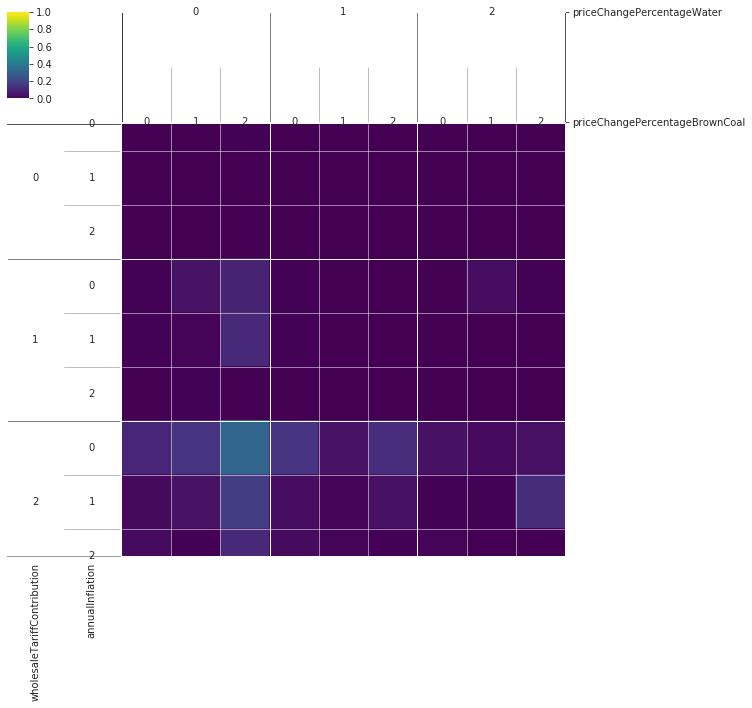

In [56]:

from EMAworkbench.ema_workbench.analysis import dimensional_stacking

x = exp
dimensional_stacking.create_pivot_plot(x,y, 2, nbins=3)
plt.show()



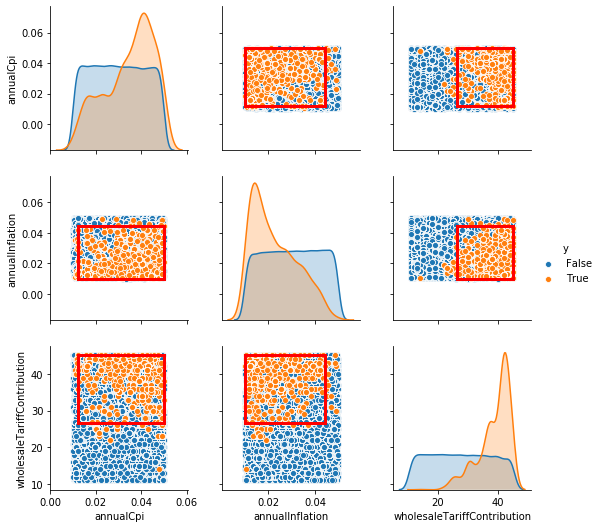

In [55]:
box1.select(12)
fig = box1.show_pairs_scatter(12)
plt.show()

Densities (PDF): {'29.7 to 30.0': '0.099', '30.0 to 30.2': '0.354', '30.2 to 30.5': '0.603', '30.5 to 30.7': '0.594', '30.7 to 30.9': '0.412', '30.9 to 31.2': '0.434', '31.2 to 31.4': '0.438', '31.4 to 31.7': '0.462', '31.7 to 31.9': '0.398', '31.9 to 32.2': '0.223', '32.2 to 32.4': '0.050'}
% in Bin: {'29.7 to 30.0': '2.4%', '30.0 to 30.2': '8.7%', '30.2 to 30.5': '14.8%', '30.5 to 30.7': '14.6%', '30.7 to 30.9': '10.1%', '30.9 to 31.2': '10.7%', '31.2 to 31.4': '10.8%', '31.4 to 31.7': '11.4%', '31.7 to 31.9': '9.8%', '31.9 to 32.2': '5.5%', '32.2 to 32.4': '1.2%'}

Densities (PDF): {'13.8 to 16.7': '0.002', '16.7 to 19.6': '0.013', '19.6 to 22.5': '0.044', '22.5 to 25.4': '0.073', '25.4 to 28.3': '0.091', '28.3 to 31.2': '0.068', '31.2 to 34.1': '0.033', '34.1 to 37.0': '0.014', '37.0 to 39.9': '0.006'}
% in Bin: {'13.8 to 16.7': '0.6%', '16.7 to 19.6': '3.7%', '19.6 to 22.5': '12.9%', '22.5 to 25.4': '21.1%', '25.4 to 28.3': '26.3%', '28.3 to 31.2': '19.7%', '31.2 to 34.1': '9.5%',

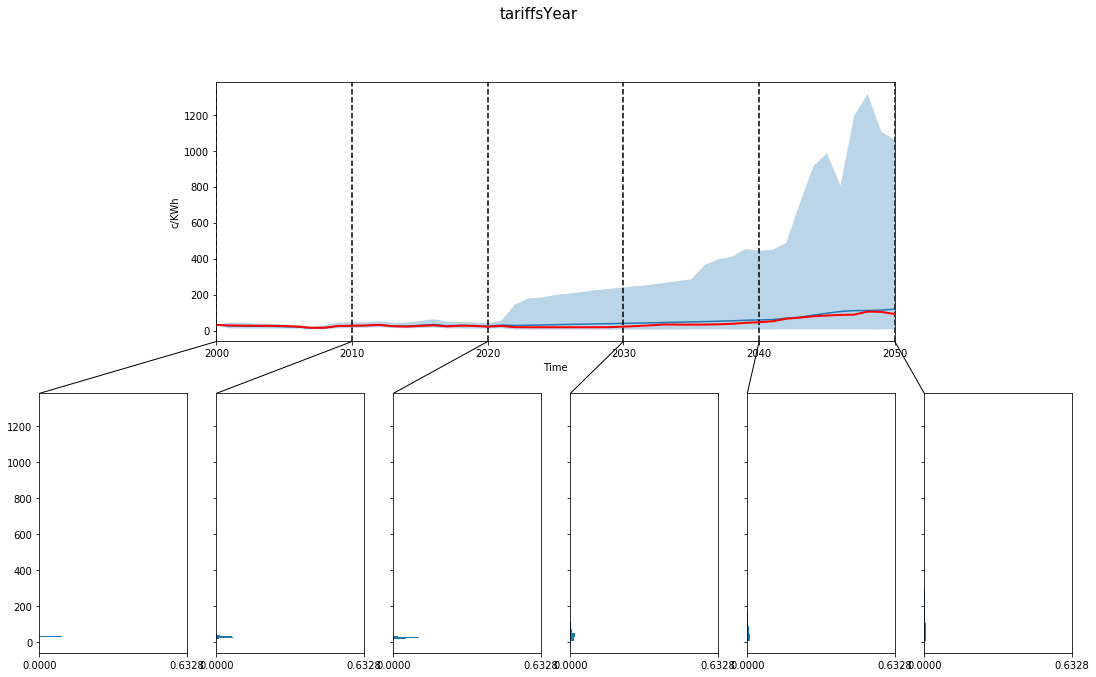

In [300]:
## Primary Spot Production

In [73]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
"""
Filter by GHG
"""    
#ooi = 'GHGYear'
#y = (out_avg_ooi < 4.)
#y = target_at_year( outcomes_filtered, ooi, 2030, 24, False) #False is below target
#y1 = target_at_year( outcomes_filtered, ooi, 2020, 38, False) #False is below target

"""
Filter by Tariff
"""

ooi = 'tariffsYear'    
x = exp
#y = out_avg_ooi > 20

#y2 = target_at_year( outcomes_filtered, ooi, 2030, 50, True) #False is below target
y = target_at_year( outcomes_filtered, ooi, 2030, 21, False) #False is below target

"""
Combine Filters
"""
#y = y1 & y2

"""
Run PRIM
"""
prim_alg = prim.Prim(x, y, threshold=0.5, threshold_type=prim.ABOVE)
box1 = prim_alg.find_box()

[MainProcess/INFO] 49153 points remaining, containing 10491 cases of interest
C:\Users\angel\Documents\GitHub\gr4sp\experiments\EMAworkbench\ema_workbench\analysis\scenario_discovery_util.py:226: RuntimeWarning:

invalid value encountered in less_equal

C:\Users\angel\Documents\GitHub\gr4sp\experiments\EMAworkbench\ema_workbench\analysis\scenario_discovery_util.py:227: RuntimeWarning:

invalid value encountered in less_equal

C:\Users\angel\Documents\GitHub\gr4sp\experiments\EMAworkbench\ema_workbench\analysis\scenario_discovery_util.py:306: RuntimeWarning:

invalid value encountered in long_scalars

C:\Users\angel\Anaconda3\lib\site-packages\scipy\stats\_discrete_distns.py:47: RuntimeWarning:

invalid value encountered in greater_equal

C:\Users\angel\Anaconda3\lib\site-packages\scipy\stats\_discrete_distns.py:47: RuntimeWarning:

invalid value encountered in less_equal

C:\Users\angel\Documents\GitHub\gr4sp\experiments\EMAworkbench\ema_workbench\analysis\prim.py:1198: RuntimeWarning:

AssertionError: 

In [52]:
box1.inspect_tradeoff()

alt.VConcatChart(...)

coverage    0.624395
density     0.848195
id                11
mass        0.325128
mean        0.848195
res_dim            3
Name: 11, dtype: object

                            box 11                                     
                               min   max                      qp values
semiScheduleGenSpotMarket      8.0   9.5                    [-1.0, 0.0]
priceChangePercentageWind    -30.0  27.5  [-1.0, 0.0006427886079691778]
wholesaleTariffContribution   27.5  45.0                    [0.0, -1.0]



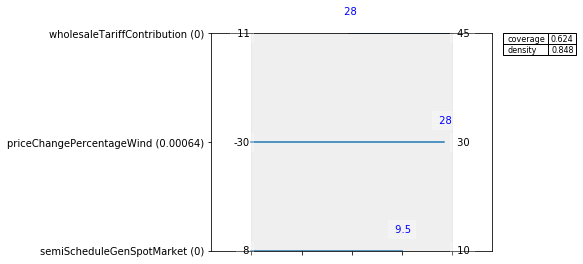

In [47]:
%matplotlib inline
box_1 = box1.inspect(11)
box_1 = box1.inspect(11, style='graph')

### Dimensional stacking

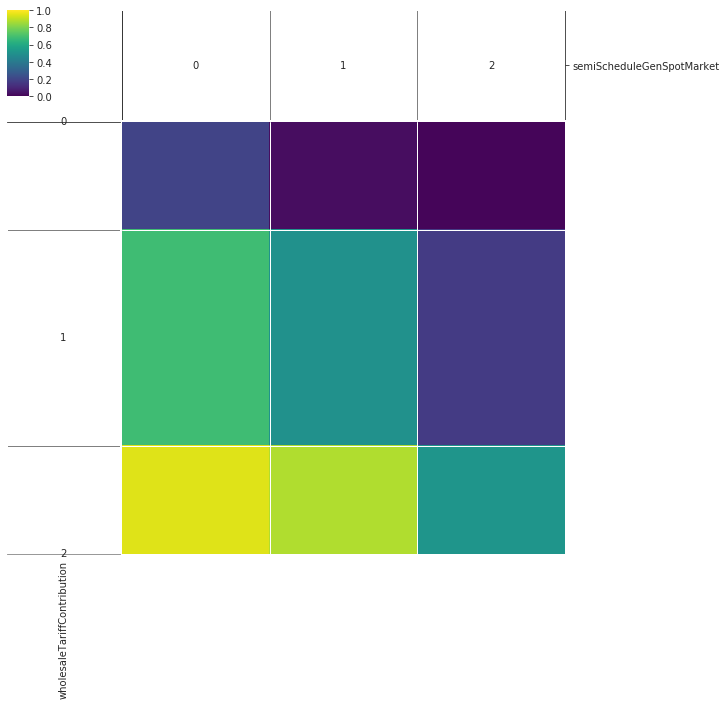

In [49]:

from EMAworkbench.ema_workbench.analysis import dimensional_stacking

x = exp
dimensional_stacking.create_pivot_plot(x,y, 1, nbins=3)
plt.show()



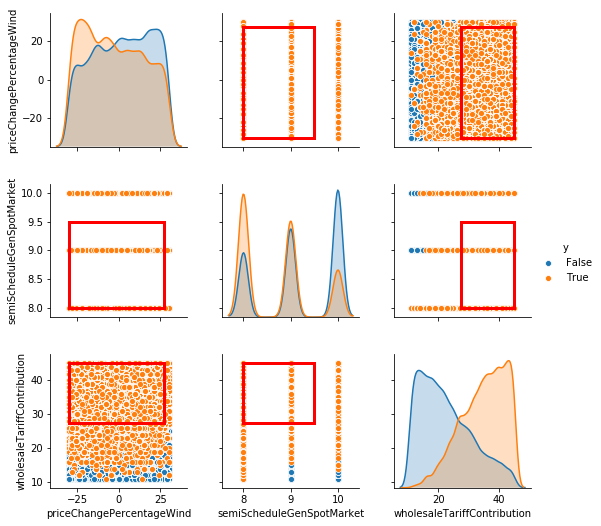

In [50]:
box1.select(11)
fig = box1.show_pairs_scatter(11)
plt.show()

## Primary Spot Production

In [ ]:
# Subset Sool levers/uncertainties
selected_uncertainties = list(['annualCpi','priceChangePercentageWind','priceChangePercentageWater',
                        'semiScheduleMinCapMarketGen'])    

selected_uncertainties = uncertainties

ooi = 'primarySpotProductionYear'
data = outcomes_filtered[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_uncertainties] 

### Open Exploration: Visual Analysis

In [ ]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

In [ ]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.HIST,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

In [ ]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 40000000
y = target_at_year( outcomes_filtered, ooi, 2035, 40000000, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=0.3)
box1 = prim_alg.find_box()

In [ ]:
box1.inspect_tradeoff()

In [ ]:
%matplotlib inline
box_1 = box1.inspect(2)
box_1 = box1.inspect(2, style='graph')

In [ ]:
box1.select(2)
fig = box1.show_pairs_scatter(2)
plt.show()

## Secondary Spot Production

In [301]:
# Subset Sool levers/uncertainties
selected_uncertainties = list(['annualCpi','priceChangePercentageWind','priceChangePercentageWater',
                        'semiScheduleMinCapMarketGen'])    

selected_uncertainties = uncertainties

ooi = 'secondarySpotProductionYear'
data = outcomes_filtered[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_uncertainties] 

### Open Exploration: Visual Analysis

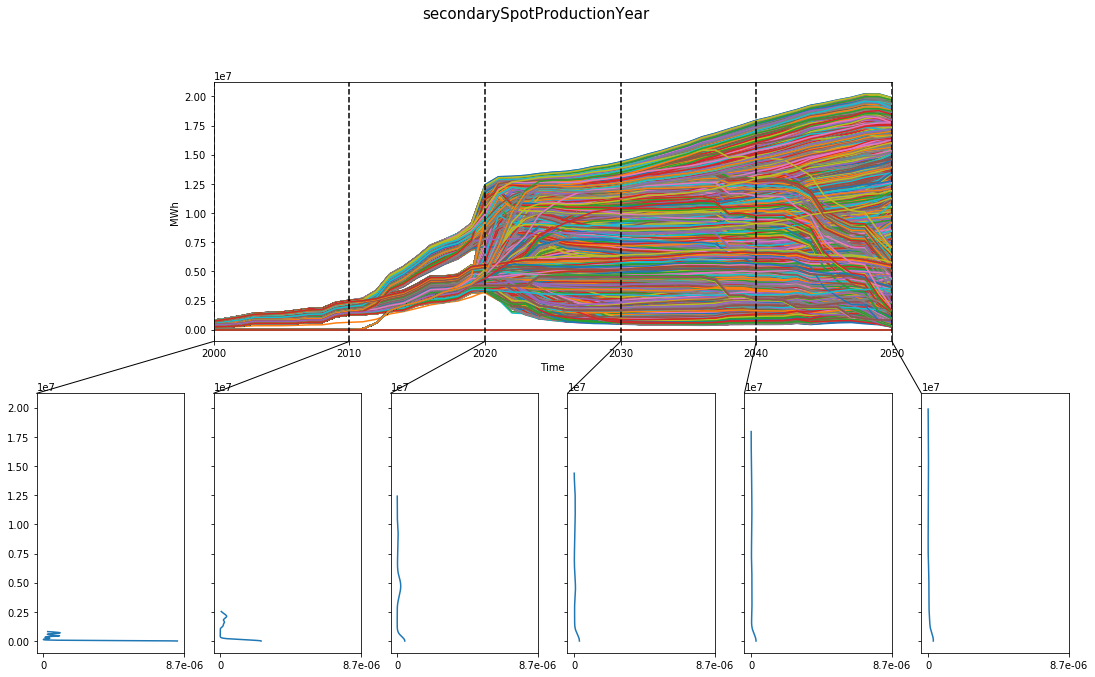

In [303]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])


fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

Densities (PDF): {}
% in Bin: {'0.0 to 73303.9': '66.6%', '73303.9 to 146607.8': '0.0%', '146607.8 to 219911.8': '0.1%', '219911.8 to 293215.7': '3.2%', '293215.7 to 366519.6': '1.0%', '366519.6 to 439823.5': '4.4%', '439823.5 to 513127.4': '6.4%', '513127.4 to 586431.3': '2.1%', '586431.3 to 659735.3': '3.1%', '659735.3 to 733039.2': '8.0%', '733039.2 to 806343.1': '5.1%'}

Densities (PDF): {}
% in Bin: {'0.0 to 229831.4': '66.6%', '229831.4 to 459662.8': '0.0%', '459662.8 to 689494.2': '0.0%', '689494.2 to 919325.6': '0.0%', '919325.6 to 1149157.1': '0.0%', '1149157.1 to 1378988.5': '3.7%', '1378988.5 to 1608819.9': '4.5%', '1608819.9 to 1838651.3': '5.2%', '1838651.3 to 2068482.7': '7.1%', '2068482.7 to 2298314.1': '9.5%', '2298314.1 to 2528145.5': '3.4%'}

Densities (PDF): {}
% in Bin: {'0.0 to 1128560.3': '44.2%', '1128560.3 to 2257120.6': '0.0%', '2257120.6 to 3385680.8': '0.1%', '3385680.8 to 4514241.1': '16.2%', '4514241.1 to 5642801.4': '21.9%', '5642801.4 to 6771361.7': '2.5%

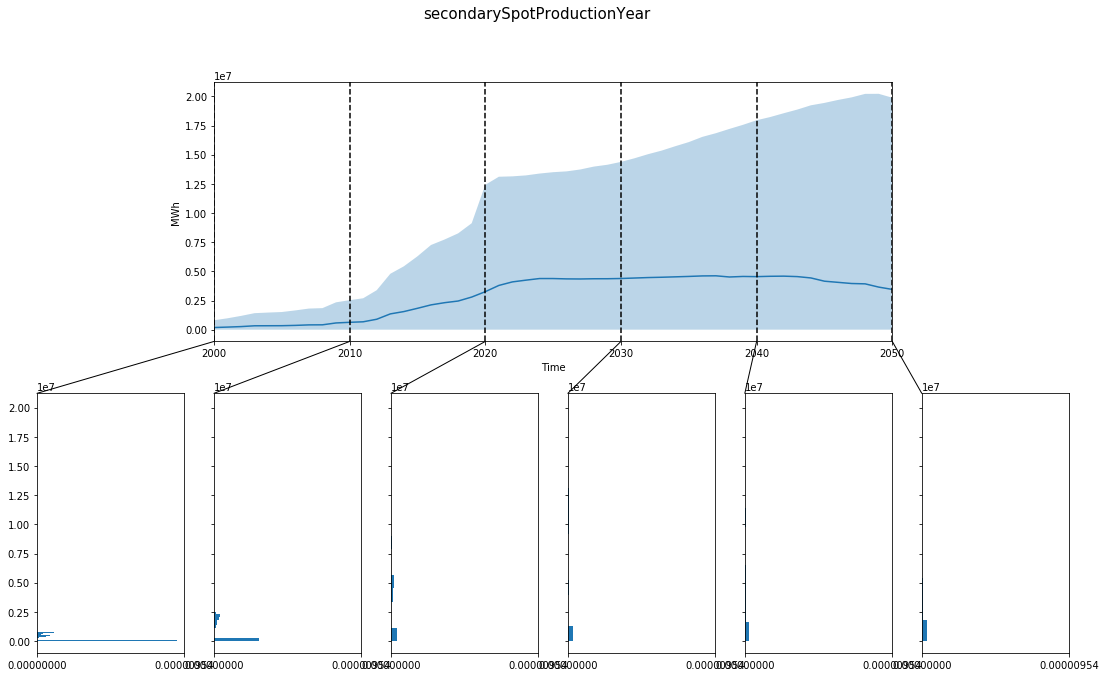

In [304]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.HIST,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

In [ ]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 40000000
y = target_at_year( outcomes_filtered, ooi, 2035, 40000000, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=0.3)
box1 = prim_alg.find_box()

In [ ]:
box1.inspect_tradeoff()

In [ ]:
%matplotlib inline
box_1 = box1.inspect(2)
box_1 = box1.inspect(2, style='graph')

In [ ]:
box1.select(2)
fig = box1.show_pairs_scatter(2)
plt.show()

## Rooftop PV Production

In [ ]:
# Subset Sool levers/uncertainties
selected_uncertainties = list(['annualCpi','priceChangePercentageWind','priceChangePercentageWater',
                        'semiScheduleMinCapMarketGen'])    

selected_uncertainties = uncertainties

ooi = 'rooftopPVProductionYear'
data = outcomes_filtered[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_uncertainties] 

### Open Exploration: Visual Analysis

In [ ]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

In [ ]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

In [ ]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 40000000
y = target_at_year( outcomes_filtered, ooi, 2035, 40000000, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=0.3)
box1 = prim_alg.find_box()

In [ ]:
box1.inspect_tradeoff()

In [ ]:
%matplotlib inline
box_1 = box1.inspect(2)
box_1 = box1.inspect(2, style='graph')

In [ ]:
box1.select(2)
fig = box1.show_pairs_scatter(2)
plt.show()

In [ ]:
box1.select(2)
fig = box1.show_pairs_scatter(2)
plt.show()

## Off Spot Production

In [ ]:
# Subset Sool levers/unceratinties
selected_uncertainties = list(['annualCpi','priceChangePercentageWind','priceChangePercentageWater',
                        'semiScheduleMinCapMarketGen'])    

selected_uncertainties = uncertainties

ooi = 'offSpotProductionYear'
data = outcomes_filtered[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_uncertainties] 

### Open Exploration: Visual Analysis

In [ ]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

In [ ]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.HIST,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

In [ ]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 40000000
y = target_at_year( outcomes_filtered, ooi, 2035, 40000000, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=0.3)
box1 = prim_alg.find_box()

In [ ]:
box1.inspect_tradeoff()

In [ ]:
%matplotlib inline
box_1 = box1.inspect(2)
box_1 = box1.inspect(2, style='graph')

In [ ]:
box1.select(2)
fig = box1.show_pairs_scatter(2)
plt.show()

## Renewable Energies in the System

In [ ]:
# Subset Sool levers/uncertainties
selected_uncertainties = list(['annualCpi','priceChangePercentageWind','priceChangePercentageWater',
                        'semiScheduleMinCapMarketGen'])    

selected_uncertainties = uncertainties

ooi = 'renewableContributionYear'
data = outcomes_filtered[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_uncertainties] 

### Open Exploration: Visual Analysis

In [ ]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "% Renewable"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

In [ ]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.HIST,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "% Renewable"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

In [ ]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 40000000
y = target_at_year( outcomes_filtered, ooi, 2035, 40000000, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=0.3)
box1 = prim_alg.find_box()

In [ ]:
box1.select(2)
fig = box1.show_pairs_scatter(2)
plt.show()

In [ ]:
box1.select(2)
fig = box1.show_pairs_scatter(2)
plt.show()

## Coal Production

In [ ]:
# Subset Sool levers/uncertainties
selected_uncertainties = list(['annualCpi','priceChangePercentageWind','priceChangePercentageWater',
                        'semiScheduleMinCapMarketGen'])    

selected_uncertainties = uncertainties

ooi = 'coalProductionYear'
data = outcomes_filtered[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_uncertainties] 

### Open Exploration: Visual Analysis

In [ ]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

In [ ]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.HIST,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

In [ ]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 40000000
y = target_at_year( outcomes_filtered, ooi, 2035, 40000000, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=0.3)
box1 = prim_alg.find_box()

In [ ]:
box1.inspect_tradeoff()

In [ ]:
%matplotlib inline
box_1 = box1.inspect(2)
box_1 = box1.inspect(2, style='graph')

In [ ]:
box1.select(2)
fig = box1.show_pairs_scatter(2)
plt.show()

## Water Production

In [ ]:
# Subset Sool levers
selected_uncertainties = list(['annualCpi','priceChangePercentageWind','priceChangePercentageWater',
                        'semiScheduleMinCapMarketGen'])    

selected_uncertainties = uncertainties

ooi = 'waterProductionYear'
data = outcomes_filtered[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_uncertainties] 

### Open Exploration: Visual Analysis

In [ ]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

In [ ]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.HIST,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

In [ ]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 40000000
y = target_at_year( outcomes_filtered, ooi, 2035, 40000000, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=0.3)
box1 = prim_alg.find_box()

In [ ]:
box1.inspect_tradeoff()

In [ ]:
%matplotlib inline
box_1 = box1.inspect(2)
box_1 = box1.inspect(2, style='graph')

In [ ]:
box1.select(2)
fig = box1.show_pairs_scatter(2)
plt.show()

## Wind Production

In [ ]:
# Subset Sool levers
selected_uncertainties = list(['annualCpi','priceChangePercentageWind','priceChangePercentageWater',
                        'semiScheduleMinCapMarketGen'])    

selected_uncertainties = uncertainties

ooi = 'windProductionYear'
data = outcomes_filtered[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_uncertainties] 

### Open Exploration: Visual Analysis

In [ ]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

In [ ]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

In [ ]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 40000000
y = target_at_year( outcomes_filtered, ooi, 2035, 40000000, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=0.3)
box1 = prim_alg.find_box()

In [ ]:
box1.inspect_tradeoff()

In [ ]:
%matplotlib inline
box_1 = box1.inspect(2)
box_1 = box1.inspect(2, style='graph')

In [ ]:
box1.select(2)
fig = box1.show_pairs_scatter(2)
plt.show()

## Gas Production

In [ ]:
# Subset Sool levers
selected_uncertainties = list(['annualCpi','priceChangePercentageWind','priceChangePercentageWater',
                        'semiScheduleMinCapMarketGen'])    

selected_uncertainties = uncertainties

ooi = 'gasProductionYear'
data = outcomes_filtered[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_uncertainties] 

### Open Exploration: Visual Analysis

In [ ]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

In [ ]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

In [ ]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 40000000
y = target_at_year( outcomes_filtered, ooi, 2035, 40000000, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=0.3)
box1 = prim_alg.find_box()

In [ ]:
box1.inspect_tradeoff()

In [ ]:
%matplotlib inline
box_1 = box1.inspect(2)
box_1 = box1.inspect(2, style='graph')

In [ ]:
box1.select(2)
fig = box1.show_pairs_scatter(2)
plt.show()

## Solar Production

In [ ]:
# Subset Sool levers
selected_uncertainties = list(['annualCpi','priceChangePercentageWind','priceChangePercentageWater',
                        'semiScheduleMinCapMarketGen'])    

selected_uncertainties = uncertainties

ooi = 'solarProductionYear'
data = outcomes_filtered[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_uncertainties] 

### Open Exploration: Visual Analysis

In [ ]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

In [ ]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

In [ ]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 40000000
y = target_at_year( outcomes_filtered, ooi, 2035, 40000000, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=0.3)
box1 = prim_alg.find_box()

In [ ]:
box1.inspect_tradeoff()

In [ ]:
%matplotlib inline
box_1 = box1.inspect(2)
box_1 = box1.inspect(2, style='graph')

In [ ]:
box1.select(2)
fig = box1.show_pairs_scatter(2)
plt.show()

## Battery Production

In [ ]:
# Subset Sool levers
selected_uncertainties = list(['annualCpi','priceChangePercentageWind','priceChangePercentageWater',
                        'semiScheduleMinCapMarketGen'])    

selected_uncertainties = uncertainties

ooi = 'BatteryProductionYear'
data = outcomes_filtered[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_uncertainties] 

### Open Exploration: Visual Analysis

In [ ]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

In [ ]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

In [ ]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 40000000
y = target_at_year( outcomes_filtered, ooi, 2035, 40000000, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=0.3)
box1 = prim_alg.find_box()

In [ ]:
box1.inspect_tradeoff()

In [ ]:
%matplotlib inline
box_1 = box1.inspect(2)
box_1 = box1.inspect(2, style='graph')

In [ ]:
box1.select(2)
fig = box1.show_pairs_scatter(2)
plt.show()

## Consumption

In [ ]:
# Subset Sool levers
selected_uncertainties = list(['annualCpi','priceChangePercentageWind','priceChangePercentageWater',
                        'semiScheduleMinCapMarketGen'])    

selected_uncertainties = uncertainties

ooi = 'consumptionYear'
data = outcomes_filtered[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_uncertainties] 

### Open Exploration: Visual Analysis

In [ ]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

In [ ]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

In [ ]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 40000000
y = target_at_year( outcomes_filtered, ooi, 2035, 40000000, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=0.3)
box1 = prim_alg.find_box()

In [ ]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

In [ ]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 40000000
y = target_at_year( outcomes_filtered, ooi, 2035, 40000000, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=0.3)
box1 = prim_alg.find_box()

In [ ]:
box1.inspect_tradeoff()

In [ ]:
%matplotlib inline
box_1 = box1.inspect(2)
box_1 = box1.inspect(2, style='graph')

In [ ]:
box1.select(2)
fig = box1.show_pairs_scatter(2)
plt.show()

## Consumption

In [ ]:
# Subset Sool levers
selected_uncertainties = list(['annualCpi','priceChangePercentageWind','priceChangePercentageWater',
                        'semiScheduleMinCapMarketGen'])    

selected_uncertainties = uncertainties

ooi = 'consumptionYear'
data = outcomes_filtered[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_uncertainties] 

### Open Exploration: Visual Analysis

In [ ]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

In [ ]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

In [ ]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 40000000
y = target_at_year( outcomes_filtered, ooi, 2035, 40000000, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=0.3)
box1 = prim_alg.find_box()

In [ ]:
box1.inspect_tradeoff()

In [ ]:
%matplotlib inline
box_1 = box1.inspect(2)
box_1 = box1.inspect(2, style='graph')

In [ ]:
box1.select(2)
fig = box1.show_pairs_scatter(2)
plt.show()